In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import tensorflow.keras as keras

Data Pipeline

In [2]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True ,exist_ok=True)
        url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing.csv"))        

In [3]:
housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
dataset_path = Path("datasets/housing.csv")
dataset_line = tf.data.TextLineDataset(str(dataset_path))
record_defaults = [tf.constant([0.], dtype=tf.float32)] * 7 + [tf.constant([0.], dtype=tf.float32)] * 2 + [tf.constant([], dtype=tf.string)] 

In [6]:
def parserx(line):
    x = tf.io.decode_csv(line, record_defaults=record_defaults)
    features1 = tf.stack(x[:8])
    features2 = tf.stack(tf.concat([x[0:2], x[3:5]], axis=0))
    return features1 , features2
def parsery(line):
    x = tf.io.decode_csv(line, record_defaults=record_defaults)
    return tf.stack(x[8])

In [7]:
data_x = dataset_line.skip(1).map(parserx)
data_y = dataset_line.skip(1).map(parsery)

In [8]:
data_x_wide_array = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)
data_x_deep_array = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)
data_y_array = tf.TensorArray(tf.float32, size = 0, dynamic_size = True)

In [9]:
for x, y in data_x:
    data_x_deep_array = data_x_deep_array.write(data_x_deep_array.size(), x)
    data_x_wide_array = data_x_wide_array.write(data_x_wide_array.size(), y)

In [10]:
train_x_deep = data_x_deep_array.stack()
train_x_wide = data_x_wide_array.stack()

In [11]:
for f in data_y:
    data_y_array = data_y_array.write(data_y_array.size(), f)

In [12]:
train_y = data_y_array.stack()

In [13]:
tf.reshape(train_y , (train_y.shape[0], 1))

<tf.Tensor: shape=(20640, 1), dtype=float32, numpy=
array([[452600.],
       [358500.],
       [352100.],
       ...,
       [ 92300.],
       [ 84700.],
       [ 89400.]], dtype=float32)>

## Utility Functions

In [14]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir='my_logs'):
  return Path(root_logdir)/strftime('rin_%Y_%m_%d_%H_%M_%S')

run_logdir = get_run_logdir()

## Model:

In [15]:
class RTGaussianRegNoiseLayer(tf.keras.layers.Layer):
  def __init__(self,units, stddev ,activation = None, **kwargs):
    super().__init__(**kwargs)
    self.stddev = stddev
    self.units = units
    self.activation = tf.keras.activations.get(activation)

  def build(self, batch_input_shape):

    self.kernel = self.add_weight(name = 'kernel',
                                  shape = [batch_input_shape[-1], self.units],
                                  initializer = tf.keras.initializers.GlorotNormal())
    self.bias = self.add_weight(name = 'bias',
                                shape = [self.units],
                                initializer = tf.keras.initializers.Zeros())

  def call(self, X , training = False):
    self.batch_size = tf.shape(X)[0]
    noise = tf.random.normal(shape = [self.batch_size, self.units], stddev = self.stddev)
    if training :
      if self.activation is not None:
        return self.activation(tf.matmul(X, self.kernel) + self.bias) + noise
      else:
        return tf.matmul(X, self.kernel) + self.bias + noise
    else:
      if self.activation is not None:
        return self.activation(tf.matmul(X, self.kernel) + self.bias)
      else:
        return tf.matmul(X, self.kernel) + self.bias

  def get_config(self):
    base_config = super().get_config()
    return {**base_config , 'units': self.units ,
            'activation' : tf.keras.activations.serialize(self.activation)}

In [16]:
@tf.keras.utils.register_keras_serializable()
class DualIOGaussianRT(tf.keras.Model):
 def __init__(self, architecture, keen_units, layer_depth, g_units , **kwargs):
        super().__init__(**kwargs)
        self.architecture = architecture
        self.keen_units = keen_units
        self.g_units = g_units
        self.layer_depth = layer_depth
        
        self.DeepFlow_ = [tf.keras.layers.Dense(units, activation = 'relu',
                                                kernel_initializer = tf.keras.initializers.GlorotNormal(),
                                                kernel_regularizer = tf.keras.regularizers.L2(0.1)) for units in architecture]
        self.BatchNormDeep_ = [tf.keras.layers.BatchNormalization() for _ in architecture]
        self.WideFlow = [tf.keras.layers.Dense(keen_units,
                                               activation = tf.keras.activations.relu,
                                               kernel_initializer = tf.keras.initializers.HeNormal(),
                                               kernel_regularizer= tf.keras.regularizers.L2(0.1)) for _ in range(self.layer_depth)]
        self.BatchNormWide_ = tf.keras.layers.BatchNormalization()
        self.GRNlayer  = RTGaussianRegNoiseLayer(g_units, 0.1, activation = 'relu')
        self.concatenate_ = tf.keras.layers.Concatenate()
        self.output_1 = tf.keras.layers.Dense(1,name='output_1', activation = tf.keras.activations.linear,
                                              kernel_initializer = tf.keras.initializers.GlorotNormal())
        self.output_2 = tf.keras.layers.Dense(1,name = 'output_2', activation = tf.keras.activations.linear,
                                              kernel_initializer = tf.keras.initializers.GlorotNormal())
        
 def call(self, input):
        x_deep , x_wide = input[0] , input[1]
        
       
        for layer, norm in zip(self.DeepFlow_, self.BatchNormDeep_):
            x_deep = layer(x_deep)
            x_deep = norm(x_deep)
        for l in self.WideFlow:
            x_wide = l(x_wide)
        x_wide = self.BatchNormWide_(x_wide)
        x_wide = self.GRNlayer(x_wide)
        x = self.concatenate_([x_deep, x_wide])
        out_1 = self.output_1(x)
        out_2 = self.output_2(x_deep)
        return {'output_1': out_1, 'output_2': out_2}

 def get_config(self):
        base_config = super().get_config()
        base_config.update({'architecture':self.architecture,
                            'keen_units':self.keen_units,
                            'g_units':self.g_units,
                            'layer_depth':self.layer_depth})
        return base_config

In [17]:
import keras_tuner as kt
class DualIOGaussianRTTuner(kt.HyperModel):
    def build(self, hp):
        architecture_depth = hp.Int('architecture_depth', min_value = 6, max_value=16)
        architecture = [hp.Int(f'architecture_{i}', min_value=32, max_value=256, step=32) for i in range(architecture_depth)]
        keen_units = hp.Int('keen_units', min_value=32, max_value=128, step=32)
        g_units = hp.Int('g_units', min_value=8, max_value=128, step=32)
        layer_depth = hp.Int('layer_depth', min_value=3, max_value=8)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        optimizer = hp.Choice('optimizer',  values = ['adam', 'rmsprop'])
        if optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate)

        model = DualIOGaussianRT(architecture, keen_units, layer_depth, g_units)
        model.compile(loss = {'output_1':tf.keras.losses.MeanSquaredError(),
                              'output_2':tf.keras.losses.MeanSquaredError()},
                      optimizer = optimizer,
                      metrics = {'output_1':[tf.keras.metrics.RootMeanSquaredError()],
                                 'output_2':[tf.keras.metrics.RootMeanSquaredError()]})          
        return model

In [18]:
objective = kt.Objective('val_loss', direction='min')
HyperModelTuner = kt.RandomSearch(hypermodel=DualIOGaussianRTTuner(),
                                  objective=objective,
                                  max_trials=25,
                                  overwrite = True,
                                  directory='tuner_dir',
                                  project_name='DualIOGaussianRT',
                                  seed=42,
                                  max_consecutive_failed_trials=5)

In [20]:
HyperModelTuner.search([train_x_deep, train_x_wide], {'output_1' : train_y, 'output_2': train_y}, epochs=30, validation_split=0.2)

Trial 25 Complete [00h 00m 56s]
val_loss: 10023739392.0

Best val_loss So Far: 9088507904.0
Total elapsed time: 00h 31m 33s


In [21]:
HyperModelTuner.get_best_hyperparameters()[0].values

{'architecture_depth': 8,
 'architecture_0': 32,
 'architecture_1': 256,
 'architecture_2': 256,
 'architecture_3': 96,
 'architecture_4': 32,
 'architecture_5': 256,
 'keen_units': 64,
 'g_units': 72,
 'layer_depth': 8,
 'learning_rate': 0.006838349735093645,
 'optimizer': 'adam',
 'architecture_6': 192,
 'architecture_7': 160,
 'architecture_8': 160,
 'architecture_9': 160,
 'architecture_10': 64,
 'architecture_11': 64,
 'architecture_12': 224,
 'architecture_13': 32,
 'architecture_14': 256,
 'architecture_15': 256}

In [22]:
lr = HyperModelTuner.get_best_hyperparameters()[0].values['learning_rate']
architecture = [HyperModelTuner.get_best_hyperparameters()[0].values[f'architecture_{i}'] for i in range(HyperModelTuner.get_best_hyperparameters()[0].values['architecture_depth'])]
ku = HyperModelTuner.get_best_hyperparameters()[0].values['keen_units']
gu = HyperModelTuner.get_best_hyperparameters()[0].values['g_units']
ld = HyperModelTuner.get_best_hyperparameters()[0].values['layer_depth']

In [23]:
model = DualIOGaussianRT(architecture, ku, ld, gu)

In [24]:
model.compile(loss = {'output_1':tf.keras.losses.MeanSquaredError(),
                        'output_2':tf.keras.losses.MeanSquaredError()},
                optimizer = tf.keras.optimizers.Adam(lr),
                metrics = {'output_1':[tf.keras.metrics.RootMeanSquaredError()],
                             'output_2':[tf.keras.metrics.RootMeanSquaredError()]})

In [25]:
model.fit([train_x_deep, train_x_wide], {'output_1':train_y, 'output_2':train_y}, epochs=100, validation_split=0.2 , callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = 'best_model.keras',
                                                                                                                                         monitor = 'val_loss',
                                                                                                                                         save_best_only = True,
                                                                                                                                         save_weights_only = False,
                                                                                                                                         mode = 'min',
                                                                                                                                         verbose =1),
                                                                                                                                         tf.keras.callbacks.TensorBoard(run_logdir)])

Epoch 1/100
511/516 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47529684992.0000 - output_1_root_mean_squared_error: 152149.3281 - output_2_root_mean_squared_error: 151989.7969
Epoch 1: val_loss improved from inf to 66133561344.00000, saving model to best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 47339417600.0000 - output_1_root_mean_squared_error: 151825.6875 - output_2_root_mean_squared_error: 151679.7656 - val_loss: 66133561344.0000 - val_output_1_root_mean_squared_error: 176199.5312 - val_output_2_root_mean_squared_error: 187315.9688
Epoch 2/100
510/516 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20058269696.0000 - output_1_root_mean_squared_error: 99600.7734 - output_2_root_mean_squared_error: 100020.1172
Epoch 2: val_loss improved from 66133561344.00000 to 17556639744.00000, saving model to best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 20035559424.0000 - output_1_root_mean_squared_error: 99548.6875 - output_2_root_mean_squared_error: 99965.4141 -

In [19]:
best_model = tf.keras.models.load_model('best_model.keras')

In [20]:
y_pred = best_model.predict([train_x_deep, train_x_wide])

645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [21]:
y_pred_main , y_pred_aux = y_pred['output_1'] , y_pred['output_2']

In [22]:
y_pred_main[0:10] , train_y[0:10]

(array([[473116.94],
        [506254.25],
        [446086.38],
        [382780.06],
        [307152.94],
        [348559.7 ],
        [329179.16],
        [424699.2 ],
        [212631.56],
        [367889.38]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([452600., 358500., 352100., 341300., 342200., 269700., 299200.,
        241400., 226700., 261100.], dtype=float32)>)

In [23]:
best_model.layers

[<Dense name=dense_9, built=True>,
 <Dense name=dense_10, built=True>,
 <Dense name=dense_11, built=True>,
 <Dense name=dense_12, built=True>,
 <Dense name=dense_13, built=True>,
 <Dense name=dense_14, built=True>,
 <Dense name=dense_15, built=True>,
 <Dense name=dense_16, built=True>,
 <BatchNormalization name=batch_normalization_7, built=True>,
 <BatchNormalization name=batch_normalization_8, built=True>,
 <BatchNormalization name=batch_normalization_9, built=True>,
 <BatchNormalization name=batch_normalization_10, built=True>,
 <BatchNormalization name=batch_normalization_11, built=True>,
 <BatchNormalization name=batch_normalization_12, built=True>,
 <BatchNormalization name=batch_normalization_13, built=True>,
 <BatchNormalization name=batch_normalization_14, built=True>,
 <Dense name=dense_17, built=True>,
 <Dense name=dense_18, built=True>,
 <Dense name=dense_19, built=True>,
 <Dense name=dense_20, built=True>,
 <Dense name=dense_21, built=True>,
 <Dense name=dense_22, built=Tru

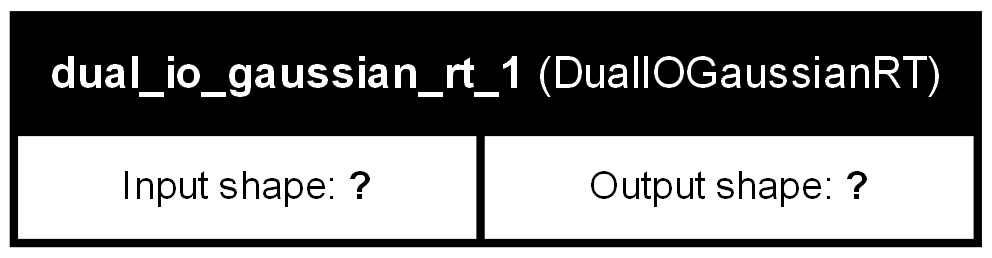

In [24]:
tf.keras.utils.plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)